# Hello Triangle!

In this tutorial, we will create a simple "hello triangle," which is a "hello world" of graphics programming, using DRTK.

## Imports

First, we import ``drtk`` and ``torch``. We will also need ``save_image`` from ``torchvision``
and ``display`` from ``IPython`` to show images.

In [1]:
import drtk
import torch as th
import torch.nn.functional as thf
from IPython.display import display
from torchvision.utils import save_image
from PIL import Image

I0930 183935.688 _utils_internal.py:314] NCCL_DEBUG env var is set to None


I0930 183935.691 _utils_internal.py:323] NCCL_DEBUG is INFO from /etc/nccl.conf


## Preparing geometry

### Vertex Buffer
Next we create a tensor that holds vertex positions (also known as vertex buffer), 
which should have a shape of $(B \times N \times 3)$, where $B$ is the batch dimension,
$N$ number of vertices, and $3$ is the coordinates' dimension.

In this example, we create a tensor of shape $(1 \times 1 \times 3)$ that holds positions 
of three vertices of the triangle we want to display a single triangle. 
The first 2 coordinates coorespond to $(x, y)$ coordinates in the image place, 
were coordinates $(0, 0)$ correspond to the center of the top-left pixel, 
and $( \text{width} - 1, \text{height} - 1)$ corresponds to bottom-right pixel.

Next, we create a tensor to hold the vertex positions (also known as the vertex buffer),
which should have a shape of $(B \times N \times 3)$, where $B$ is the batch dimension,
$N$ is the number of vertices, and $3$ represents the coordinates' dimensions.

In this example, we create a tensor of shape $(1 \times 3 \times 3)$ that holds the positions
of the three vertices of the triangle we want to display. 
The first two coordinate values correspond to the $(x, y)$ coordinates in the image plane,
where $(0, 0)$ correspond to the center of the top-left pixel, 
and $(\text{width} - 1, \text{height} - 1)$ corresponds to the center of the bottom-right pixel. 
The last coordinate is the `z`, or depth coordinate in camera frame. It is needed for perspective
correct interpolation, z-test, and culling primitive that are behind the camera. Here we set all 
`z` coordinates to $1$ for simplicity.

Note: 
> Top-left cornder of the image will have coordinates $(-0.5, -0.5)$, and bottom-right corner of
 the image will have coordinates $(\text{width} - 0.5, \text{height} - 0.5)$. 
 This matched the `align_corner=False` convention used in PyTorch, which is also in alignment with most
 of graphics APIs (e.g. OpenGL, Vulkan). 


In [2]:
# create vertex buffer of shape [1 x n_vertices x 3], here for one triangle `n_vertices` == 3
v = th.as_tensor([[[0, 511.5, 1], [255, 0, 1], [511.5, 511.5, 1]]]).float().cuda()

### Index buffer

Next, we create a tensor to holds the vertex indices (also known as index buffer), 
which should have a shape of $(F \times 3)$, where $F$ is number of triangles,
and $3$ is the dimension of the vertex indices within the triangle.

Index buffer is needed to construct primitives (triangles, in our case) out of the vertex buffer. 
It acts as a pointer array, referencing the vertices in the vertex buffer, 
allowing multiple triangles to share the same vertices.

In our case, since we have only three vertices in total, the index buffer is simply $[0, 1, 2]$.

In [3]:
# create index buffer of shape [n_faces x 3], here for one triangle `n_faces` == 1
vi = th.as_tensor([[0, 1, 2]]).int().cuda()

## Rasterize

Next, we call raterize function. We pass the vertex buffer `v`, index buffer `vi`
and specify the size of the image plane.

In [4]:
index_img = drtk.rasterize(v, vi, height=512, width=512)

The index image, `index_img`, returned by `drtk.rasterize` function, will contain the value $0$ for all pixels whose centers are covered
by the triangle, and $-1$ for all other pixels.

In the general case, `index_img` will contain indices corresponding to the triangle index in the
index buffer `vi` for the pixels whose centers are covered by that triangle. 
If multiple triangles cover the same pixel, the index of the triangle with the smallest 
rasterized depth at that pixel (greater than zero) will be used.

The index image, `index_img` has shape of $(B \times height \times width)$, where $B$ is the batch dimension.

Let's inspect the values and shape of `index_img`.

Shape: torch.Size([1, 512, 512])
Min value: -1
Max value: 0


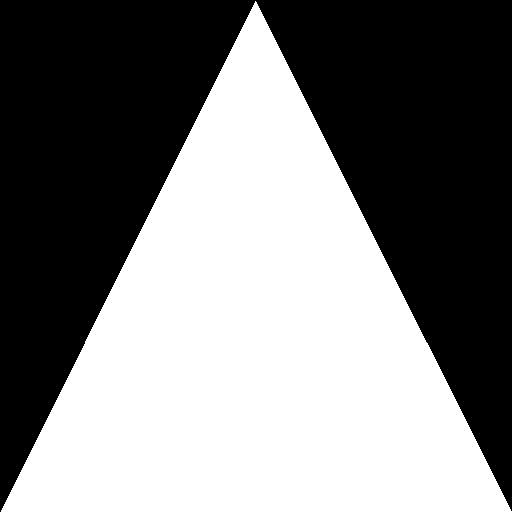

In [5]:
print(f"Shape: {index_img.shape}")
print(f"Min value: {index_img.min()}")
print(f"Max value: {index_img.max()}")

save_image((index_img != -1).float(), "img.png")
display(Image.open("img.png"))

## Render

Next, we compute the barycentric coordinates image `bary_img`. 
For each pixel, this tensor will store the barycentric coordinates of the fragment associated
with that pixel.

The tensor `bary_img` has a shape of $(B \times 3 \times \text{height} \times \text{width})$,
where $B$ is the batch dimension, and $3$ is the dimension of the barycentric coordinates.

For pixels not covered by any triangles, the barycentric coordinates will be set to zero.

Shape of bary: torch.Size([1, 3, 512, 512])
Min value: 0.0
Max value: 0.99853515625


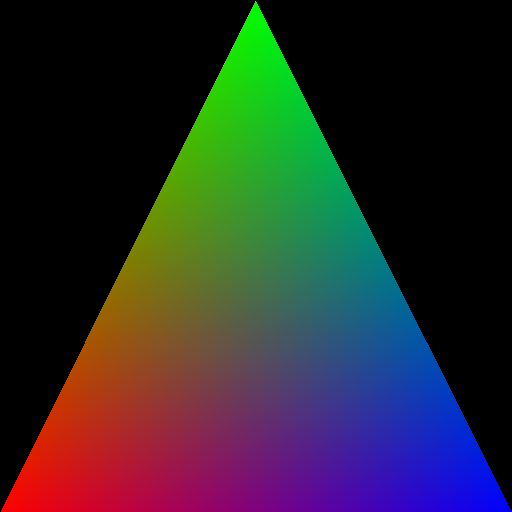

In [6]:
_, bary_img = drtk.render(v, vi, index_img)

print(f"Shape of bary: {bary_img.shape}")
print(f"Min value: {bary_img.min()}")
print(f"Max value: {bary_img.max()}")

save_image(bary_img, "img.png")
display(Image.open("img.png"))

Next, we can use function `drtk.interpolate` to interpolate the attributes of the triangle vertices using the barycentric coordinates. 
The function returns a tensor of shape $(B \times A \times \text{height} \times \text{width})$, 
where $A$ is the size of the attribute.

For this example, we will asign some colors to the vertices and interpolate them. Note that the
attribute buffer should be of shape $(B, A, N)$, where $N$ is number of vertices.

Note:
> We have to compute `mask` as
>> ```
>> mask = index_img != -1
>> ```

> So that we could zero-out values of pixels not covered by the triangle. 
Unlike `drtk.render`, the `drtk.interpolate` function will not set those pixels to zero.

Shape of rgb_img: torch.Size([1, 3, 512, 512])
Min value: 0.0
Max value: 0.8990218639373779


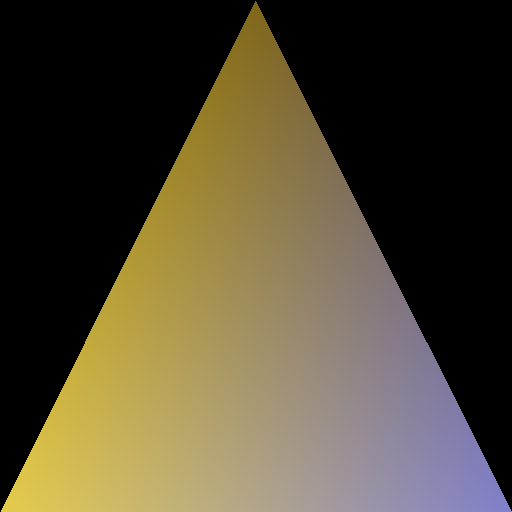

In [7]:
va = th.as_tensor([[[0.9, 0.8, 0.3], [0.5, 0.4, 0.1], [0.5, 0.5, 0.8]]]).float().cuda()

mask = index_img != -1
rgb_img = drtk.interpolate(va, vi, index_img, bary_img) * mask[:, None]

print(f"Shape of rgb_img: {rgb_img.shape}")
print(f"Min value: {rgb_img.min()}")
print(f"Max value: {rgb_img.max()}")

save_image(rgb_img, "img.png")
display(Image.open("img.png"))

## Texturing

Next, we will add texture coordinates and sample a texture.

Let's prepare a texture:

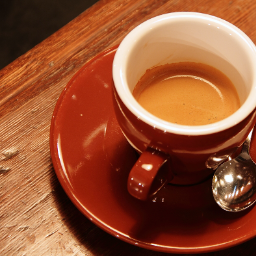

In [8]:
import skimage

tex = (
    th.as_tensor(skimage.data.coffee(), dtype=th.float32)
    .permute(2, 0, 1)[None, ...]
    .mul(1 / 255)
    .contiguous()
    .cuda()
)

tex = thf.interpolate(tex, scale_factor=0.65, mode="bilinear", align_corners=False)
tex = tex[:, :, :256, :256]

save_image(tex, "img.png")
display(Image.open("img.png"))

### Texture Coordinates

Next, we create a vertex buffer with texture coordinates, and interpolate it with `drtk.interpolate`.

Note that texture coordinates values for non-covered pixels are non-zero. 
That is intensional, we will remove those pixels after we sample the texture.

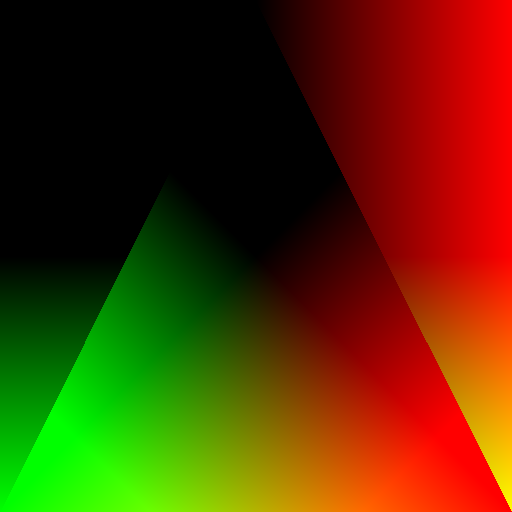

In [9]:
vt = (
    th.as_tensor([[[-1.0, 1.0], [0.0, -1.0], [1.0, 1.0]]]).float().cuda()
    # add rotation to make it more interesting 
    @ th.as_tensor([[[0.707, -0.707], [0.707, 0.707]]]).float().cuda()
)

vt_img = drtk.interpolate(vt, vi, index_img, bary_img)

save_image(th.cat([vt_img, th.zeros_like(vt_img[:, :1])], dim=1), "img.png")
display(Image.open("img.png"))

### Sampling texture

To sample the texture, we simply use `torch.nn.functional.grid_sample`.

We recommed to always useing the following set of flags:

> ```mode="bilinear", padding_mode="border", align_corners = False```

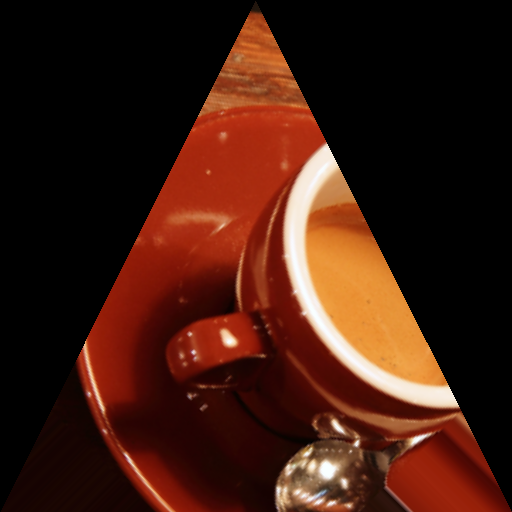

In [10]:
rgb_img = (
    thf.grid_sample(
        tex,
        vt_img.permute(0, 2, 3, 1),
        mode="bilinear",
        padding_mode="border",
        align_corners=False,
    )
    * mask[:, None]
)

save_image(rgb_img, "img.png")
display(Image.open("img.png"))

This concludes the "Hello Triangle" tutorial.